In [1]:
import datetime

import numpy as np
from scipy import signal
import matplotlib.pyplot as plt

# Make numpy values easier to read.
np.set_printoptions(precision=3, suppress=True)

import tensorflow as tf
from tensorflow.keras import layers, initializers, regularizers
import tensorflow.keras.backend as K

# fix CUDNN_STATUS_INTERNAL_ERROR
from tensorflow.compat.v1 import ConfigProto
from tensorflow.compat.v1 import InteractiveSession

config = ConfigProto()
config.gpu_options.allow_growth = True
session = InteractiveSession(config=config)

# Load TensorBoard
%load_ext tensorboard

In [2]:
# Convert from 64 to 32 bit floats
X_test = np.load("../data/X_test.npy").astype(np.float32)
y_test = np.load("../data/y_test.npy").astype(np.float32)
person_train_valid = np.load("../data/person_train_valid.npy").astype(np.float32)
X_train_valid = np.load("../data/X_train_valid.npy").astype(np.float32)
y_train_valid = np.load("../data/y_train_valid.npy").astype(np.float32)
person_test = np.load("../data/person_test.npy").astype(np.float32)

# adjust labels 
y_train_valid -= 769
y_test -= 769

print ('Training/Valid data shape: {}'.format(X_train_valid.shape))
print ('Test data shape: {}'.format(X_test.shape))
print ('Training/Valid target shape: {}'.format(y_train_valid.shape))
print ('Test target shape: {}'.format(y_test.shape))
print ('Person train/valid shape: {}'.format(person_train_valid.shape))
print ('Person test shape: {}'.format(person_test.shape))
print('y_train_valid', y_train_valid[:10])

Training/Valid data shape: (2115, 22, 1000)
Test data shape: (443, 22, 1000)
Training/Valid target shape: (2115,)
Test target shape: (443,)
Person train/valid shape: (2115, 1)
Person test shape: (443, 1)
y_train_valid [2. 3. 0. 0. 0. 0. 2. 1. 3. 3.]


# Data Augmentation

## Onehot Encoding

In [3]:
def convert_to_one_hot(in_arr):
    in_arr = in_arr.reshape((in_arr.shape[0],))
    in_arr = in_arr.astype(int)
    in_arr_1h = np.zeros((in_arr.size, in_arr.max()+1))
    in_arr_1h[np.arange(in_arr.size),in_arr] = 1
    return in_arr_1h

#convert all vectors to one-hot
y_train_valid_1h = convert_to_one_hot(y_train_valid)
y_test_1h = convert_to_one_hot(y_test)

person_train_valid_1h = convert_to_one_hot(person_train_valid)
person_test_1h = convert_to_one_hot(person_test)

## Filtering
Generate two copies, one with filtering from 8-13Hz (mu band) and another 13-30Hz (beta band)

"I found a paper where they use a 5th order butterworth filter to extract the mu band (8-13Hz) and the beta band (13-30Hz), which correspond to ERD and ERS (Event-related desynchronization and event-related synchronization) (don't ask me what those mean.) The paper trains a model with our data. Just throwing this out there."

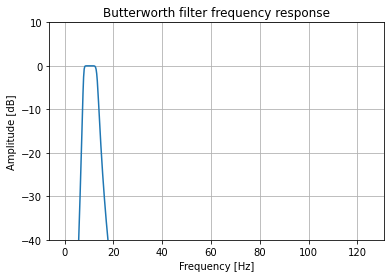

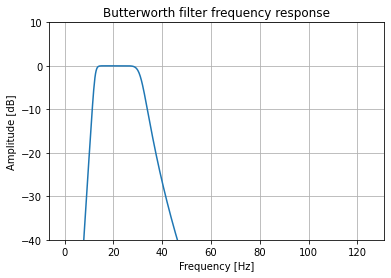

In [4]:
n, wn = signal.buttord(wp=[8, 13], ws=[6, 18], fs=250, gpass=1, gstop=36)
sos1 = signal.butter(n, wn, btype='bandpass', fs=250, output='sos')
w, h = signal.sosfreqz(sos1, fs=250)
# Stolen from scipy docs thanks guys
plt.plot(w, 20 * np.log10(abs(h) + 1e-15))
plt.title('Butterworth filter frequency response')
plt.xlabel('Frequency [Hz]')
plt.ylabel('Amplitude [dB]')
plt.ylim(-40, 10)
plt.grid(which='both', axis='both')
plt.show()

n, wn = signal.buttord(wp=[13, 30], ws=[8, 48], fs=250, gpass=1, gstop=36)
sos2 = signal.butter(n, wn, btype='bandpass', fs=250, output='sos')
w, h = signal.sosfreqz(sos2, fs=250)
plt.plot(w, 20 * np.log10(abs(h) + 1e-15))
plt.title('Butterworth filter frequency response')
plt.xlabel('Frequency [Hz]')
plt.ylabel('Amplitude [dB]')
plt.ylim(-40, 10)
plt.grid(which='both', axis='both')
plt.show()

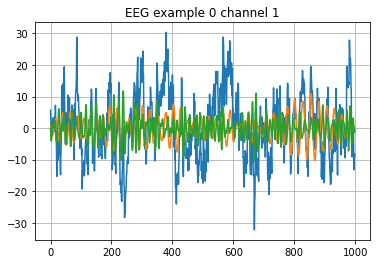

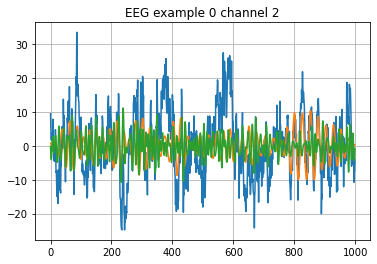

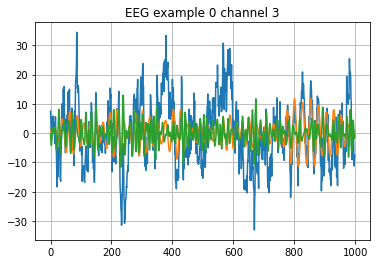

(2115, 22, 1000) -> (2115, 66, 1000)
(2115,) -> (2115,)
(443, 22, 1000) -> (443, 66, 1000)
(443,) -> (443,)


In [5]:
X_train_valid_filtered_1 = signal.sosfiltfilt(sos1, X_train_valid, axis=-1)
X_train_valid_filtered_2 = signal.sosfiltfilt(sos2, X_train_valid, axis=-1)
X_test_filtered_1 = signal.sosfiltfilt(sos1, X_test, axis=-1)
X_test_filtered_2 = signal.sosfiltfilt(sos2, X_test, axis=-1)

for i in range(3):
    plt.title("EEG example 0 channel %d" % (i+1))
    plt.plot(X_train_valid[0,i,:])
    plt.plot(X_train_valid_filtered_1[0,i,:])
    plt.plot(X_train_valid_filtered_2[0,i,:])
    plt.grid()
    plt.show()

# Concatenate filtered channels with source samples
X_train_valid_aug = np.concatenate(
    (X_train_valid, X_train_valid_filtered_1, X_train_valid_filtered_2), axis=1)
y_train_valid_aug = y_train_valid
X_test_aug = np.concatenate(
    (X_test, X_test_filtered_1, X_test_filtered_2), axis=1)
y_test_aug = y_test
print(X_train_valid.shape, "->", X_train_valid_aug.shape)
print(y_train_valid.shape, "->", y_train_valid_aug.shape)
print(X_test.shape, "->", X_test_aug.shape)
print(y_test.shape, "->", y_test_aug.shape)

## Normalize every sample to zero mean and unit variance

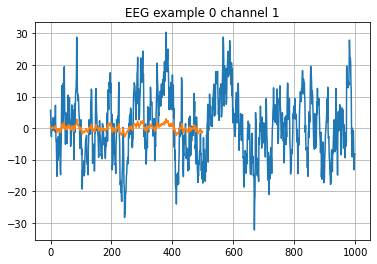

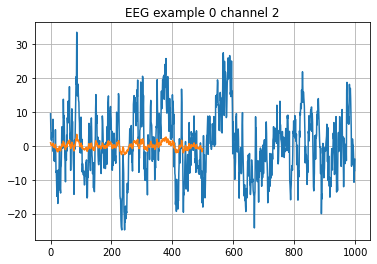

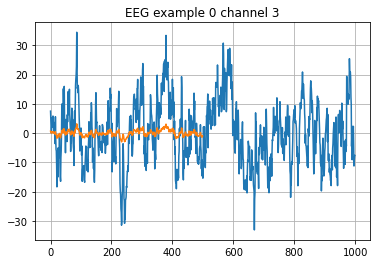

In [6]:
# Generate mutable copies
X_train_valid_norm = np.copy(X_train_valid[:,:,:500])
X_test_norm = np.copy(X_test[:,:,:500])

# Calculate and subtract the means
X_train_valid_norm -= np.expand_dims(np.mean(X_train_valid_norm, axis=-1), -1)
X_test_norm -= np.expand_dims(np.mean(X_test_norm, axis=-1), -1)

# Calculate and normalize for the standard deviations
X_train_valid_norm /= np.expand_dims(np.std(X_train_valid_norm, axis=-1), -1)
X_test_norm /= np.expand_dims(np.std(X_test_norm, axis=-1), -1)

for i in range(3):
    plt.title("EEG example 0 channel %d" % (i+1))
    plt.plot(X_train_valid[0,i,:])
    plt.plot(X_train_valid_norm[0,i,:])
    plt.grid()
    plt.show()

# Convert to TensorFlow data structure
Reference: https://www.tensorflow.org/tutorials/load_data/numpy

In [7]:
# train_dataset = tf.data.Dataset.from_tensor_slices((X_train_valid_norm, y_train_valid))
# test_dataset = tf.data.Dataset.from_tensor_slices((X_test_norm, y_test))

# Try onehot versions instead
train_dataset = tf.data.Dataset.from_tensor_slices((X_train_valid_norm, y_train_valid_1h))
test_dataset = tf.data.Dataset.from_tensor_slices((X_test_norm, y_test_1h))

print(train_dataset.element_spec)
print(test_dataset.element_spec)

BATCH_SIZE = 64
SHUFFLE_BUFFER_SIZE = 100

train_dataset = train_dataset.shuffle(SHUFFLE_BUFFER_SIZE).batch(BATCH_SIZE)
test_dataset = test_dataset.batch(BATCH_SIZE)

(TensorSpec(shape=(22, 500), dtype=tf.float32, name=None), TensorSpec(shape=(4,), dtype=tf.float64, name=None))
(TensorSpec(shape=(22, 500), dtype=tf.float32, name=None), TensorSpec(shape=(4,), dtype=tf.float64, name=None))


## Model 1
Two convolutional layers, first 1D to get per-channel features, second 2D to combine channel features into time-series.... something. I don't know, but the idea is the second layer combines each channel into time-series filters. One option has the second layer as a ConvLSTM2D with millions of parameters and the other has a Conv2D, average pool, then ConvLSTM2D to reduce the number of paramters dramatically. Both have similar performance as of right now.

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
permute_11 (Permute)         (None, 500, 22)           0         
_________________________________________________________________
dropout_14 (Dropout)         (None, 500, 22)           0         
_________________________________________________________________
conv1d_12 (Conv1D)           (None, 500, 10)           5510      
_________________________________________________________________
average_pooling1d_16 (Averag (None, 100, 10)           0         
_________________________________________________________________
batch_normalization_10 (Batc (None, 100, 10)           40        
_________________________________________________________________
reshape_21 (Reshape)         (None, 100, 10, 1)        0         
_________________________________________________________________
conv2d_12 (Conv2D)           (None, 91, 1, 40)        

14/14 [==============================] - 0s 8ms/step - loss: 0.9439 - categorical_accuracy: 0.6283 - val_loss: 1.0535 - val_categorical_accuracy: 0.5579
Epoch 36/100
14/14 [==============================] - 0s 8ms/step - loss: 0.8998 - categorical_accuracy: 0.6519 - val_loss: 0.9859 - val_categorical_accuracy: 0.5910
Epoch 37/100
14/14 [==============================] - 0s 8ms/step - loss: 0.9404 - categorical_accuracy: 0.6152 - val_loss: 0.9888 - val_categorical_accuracy: 0.6028
Epoch 38/100
14/14 [==============================] - 0s 8ms/step - loss: 0.9044 - categorical_accuracy: 0.6424 - val_loss: 1.1161 - val_categorical_accuracy: 0.5556
Epoch 39/100
14/14 [==============================] - 0s 8ms/step - loss: 0.8964 - categorical_accuracy: 0.6442 - val_loss: 1.0171 - val_categorical_accuracy: 0.5674
Epoch 40/100
14/14 [==============================] - 0s 8ms/step - loss: 0.8826 - categorical_accuracy: 0.6548 - val_loss: 1.0470 - val_categorical_accuracy: 0.5697
Epoch 41/100
14/1

14/14 [==============================] - 0s 8ms/step - loss: 0.5959 - categorical_accuracy: 0.7766 - val_loss: 1.0549 - val_categorical_accuracy: 0.6501
Epoch 85/100
14/14 [==============================] - 0s 7ms/step - loss: 0.5744 - categorical_accuracy: 0.8002 - val_loss: 0.9704 - val_categorical_accuracy: 0.6572
Epoch 86/100
14/14 [==============================] - 0s 8ms/step - loss: 0.5752 - categorical_accuracy: 0.7931 - val_loss: 1.0244 - val_categorical_accuracy: 0.6359
Epoch 87/100
14/14 [==============================] - 0s 8ms/step - loss: 0.6025 - categorical_accuracy: 0.7866 - val_loss: 1.0301 - val_categorical_accuracy: 0.6241
Epoch 88/100
14/14 [==============================] - 0s 8ms/step - loss: 0.5610 - categorical_accuracy: 0.7937 - val_loss: 1.1972 - val_categorical_accuracy: 0.6123
Epoch 89/100
14/14 [==============================] - 0s 7ms/step - loss: 0.5725 - categorical_accuracy: 0.7973 - val_loss: 1.0230 - val_categorical_accuracy: 0.6501
Epoch 90/100
14/1

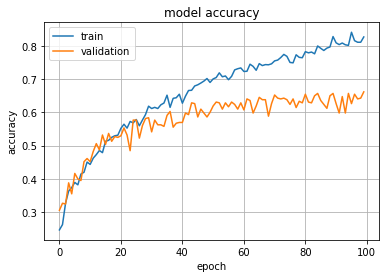

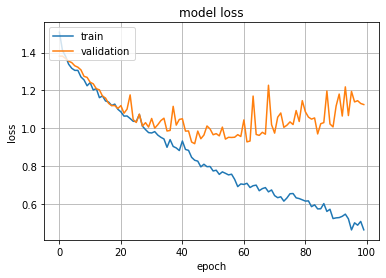

7/7 [==============================] - 0s 2ms/step - loss: 1.0891 - categorical_accuracy: 0.5914
[1.0890692472457886, 0.5914221405982971]


In [19]:
n_ch = 22
nfs = [10, 40, 10]
conv_sizes = [25, (10, nfs[0]), (5, nfs[1])]
pool_sizes = [20, 10]
pool_strides = [5, 4]
input_dropout = 0.0
fc_dropout = 0.8

# Model init
model = tf.keras.Sequential()
model.add(layers.Permute((2, 1), input_shape=(n_ch, 500)))
model.add(layers.Dropout(input_dropout, noise_shape=(1, n_ch)))

# Shape 1 - 1D
model.add(layers.Conv1D(
    filters=nfs[0], kernel_size=conv_sizes[0],
    padding='same',
    activation='elu'))
# model.add(layers.Conv1D(
#     filters=nfs[0], kernel_size=conv_sizes[0],
#     padding='same',
#     activation='elu'))
model.add(layers.AveragePooling1D(
    pool_size=pool_sizes[0], strides=pool_strides[0],
    padding='same'))
model.add(layers.BatchNormalization())

# Shape 2 - 2D, option 1 Conv2D then LSTM
model.add(layers.Reshape((500//pool_strides[0], nfs[0], 1)))
model.add(layers.Conv2D(
    filters=nfs[1], kernel_size=conv_sizes[1],
    activation='elu'))
model.add(layers.Reshape((91, nfs[1])))
model.add(layers.AveragePooling1D(
    pool_size=pool_sizes[1], strides=pool_strides[1],
    padding='same'))
model.add(layers.BatchNormalization())
model.add(layers.Reshape((23, nfs[1], 1)))
model.add(layers.Conv2D(
    filters=nfs[2], kernel_size=conv_sizes[2],
    activation='relu'))
# model.add(layers.Reshape((1, 48, nfs[1], 1)))
# model.add(layers.ConvLSTM2D(
#     filters=nfs[2], kernel_size=conv_sizes[2],
#     activation='relu'))

# Shape 2 - 2D, option 2 with ConvLSTM2D
# model.add(layers.Reshape((1, 200, 44, 1)))
# model.add(layers.ConvLSTM2D(
#     filters=nfs[1], kernel_size=conv_sizes[1],
#     activation='relu'))
# model.add(layers.Reshape((191, 50)))
# # model.add(layers.Dropout(0.5))
# model.add(layers.AveragePooling1D(
#     pool_size=pool_sizes[1], strides=pool_strides[1],
#     padding='same'))
# model.add(layers.BatchNormalization())


# FC layers
model.add(layers.Flatten())
model.add(layers.Dense(40, activation='elu'))
model.add(layers.Dropout(fc_dropout))
model.add(layers.Dense(4, activation='softmax'))

model.summary()

log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

# model.compile(optimizer=tf.keras.optimizers.Adam(1e-3),
#     loss=tf.keras.losses.SparseCategoricalCrossentropy(),
#     metrics=[tf.keras.metrics.SparseCategoricalAccuracy()])
model.compile(optimizer=tf.keras.optimizers.Adam(1e-3),
    loss=tf.keras.losses.CategoricalCrossentropy(),
    metrics=[tf.keras.metrics.CategoricalAccuracy()])

history = model.fit(
#     train_dataset,
    X_train_valid_norm, y_train_valid_1h,
    batch_size=128,
    epochs=100,
#     validation_data=test_dataset,
    validation_split=0.2,
    callbacks=[tensorboard_callback]
)

# https://machinelearningmastery.com/display-deep-learning-model-training-history-in-keras/
# list all data in history
print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['categorical_accuracy'])
plt.plot(history.history['val_categorical_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.grid()
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.grid()
plt.show()

# Evaluate model on test dataset
print(model.evaluate(test_dataset))

## Model 2
This sticks to 1D layers working on each of the 22 channels, that are combined at the end using FC nets. This has similar performance as Model 1 right now but I think it will not perform as well when data is augmented more appropriately.

In [10]:
nfs = (40, 100)
conv_sizes = (20, 10)
pool_sizes = (25, 10)
pool_strides = (10, 4)

# Model init
model = tf.keras.Sequential()
model.add(layers.Permute((2, 1), input_shape=(22, 500)))

# Shape 1
model.add(layers.Conv1D(
    filters=nfs[0], kernel_size=conv_sizes[0],
    padding='same',
    activation='elu'))
model.add(layers.Conv1D(
    filters=nfs[0], kernel_size=conv_sizes[0],
    padding='same',
    activation='elu'))
model.add(layers.AveragePooling1D(
    pool_size=pool_sizes[0], strides=pool_strides[0],
    padding='same'))
model.add(layers.BatchNormalization())

# Shape 2
model.add(layers.Conv1D(
    filters=nfs[1], kernel_size=conv_sizes[1],
    padding='same',
    activation='elu'))
model.add(layers.Conv1D(
    filters=nfs[1], kernel_size=conv_sizes[1],
    padding='same',
    activation='elu'))
model.add(layers.AveragePooling1D(
    pool_size=pool_sizes[1], strides=pool_strides[1],
    padding='same'))
model.add(layers.BatchNormalization())

# FC layers
model.add(layers.Flatten())
model.add(layers.Dropout(0.8))
# model.add(layers.Dense(25, activation='relu'))
# model.add(layers.GRU(25, activation='relu'))
model.add(layers.Dense(4, activation='softmax'))

model.summary()

log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

model.compile(optimizer=tf.keras.optimizers.Adam(1e-3),
    loss=tf.keras.losses.CategoricalCrossentropy(),
    metrics=[tf.keras.metrics.CategoricalAccuracy()])

history = model.fit(
    train_dataset,
    batch_size=128,
    epochs=100,
    validation_data=test_dataset,
    callbacks=[tensorboard_callback]
)

# https://machinelearningmastery.com/display-deep-learning-model-training-history-in-keras/
# list all data in history
print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['categorical_accuracy'])
plt.plot(history.history['val_categorical_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.grid()
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.grid()
plt.show()

# Evaluate model on test dataset
print(model.evaluate(test_dataset))

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
permute_2 (Permute)          (None, 500, 22)           0         
_________________________________________________________________
conv1d_6 (Conv1D)            (None, 500, 40)           17640     
_________________________________________________________________
conv1d_7 (Conv1D)            (None, 500, 40)           32040     
_________________________________________________________________
average_pooling1d_4 (Average (None, 50, 40)            0         
_________________________________________________________________
batch_normalization_4 (Batch (None, 50, 40)            160       
_________________________________________________________________
conv1d_8 (Conv1D)            (None, 50, 100)           40100     
_________________________________________________________________
conv1d_9 (Conv1D)            (None, 50, 100)          

Epoch 39/100
34/34 [==============================] - 0s 8ms/step - loss: 0.6773 - categorical_accuracy: 0.7385 - val_loss: 0.9983 - val_categorical_accuracy: 0.6253
Epoch 40/100
34/34 [==============================] - 0s 8ms/step - loss: 0.7128 - categorical_accuracy: 0.7187 - val_loss: 0.9475 - val_categorical_accuracy: 0.6095
Epoch 41/100
34/34 [==============================] - 0s 8ms/step - loss: 0.6409 - categorical_accuracy: 0.7456 - val_loss: 0.9986 - val_categorical_accuracy: 0.6230
Epoch 42/100
34/34 [==============================] - 0s 8ms/step - loss: 0.6146 - categorical_accuracy: 0.7612 - val_loss: 0.9544 - val_categorical_accuracy: 0.6343
Epoch 43/100
34/34 [==============================] - 0s 8ms/step - loss: 0.5800 - categorical_accuracy: 0.7759 - val_loss: 1.1883 - val_categorical_accuracy: 0.5801
Epoch 44/100
34/34 [==============================] - 0s 8ms/step - loss: 0.6730 - categorical_accuracy: 0.7418 - val_loss: 1.1159 - val_categorical_accuracy: 0.6321
Epoc

34/34 [==============================] - 0s 8ms/step - loss: 0.2253 - categorical_accuracy: 0.9121 - val_loss: 1.6838 - val_categorical_accuracy: 0.6298
Epoch 89/100
34/34 [==============================] - 0s 8ms/step - loss: 0.2205 - categorical_accuracy: 0.9243 - val_loss: 1.4633 - val_categorical_accuracy: 0.6343
Epoch 90/100
34/34 [==============================] - 0s 8ms/step - loss: 0.1564 - categorical_accuracy: 0.9433 - val_loss: 1.4561 - val_categorical_accuracy: 0.6591
Epoch 91/100
34/34 [==============================] - 0s 8ms/step - loss: 0.1434 - categorical_accuracy: 0.9480 - val_loss: 1.3378 - val_categorical_accuracy: 0.6772
Epoch 92/100
34/34 [==============================] - 0s 8ms/step - loss: 0.1158 - categorical_accuracy: 0.9551 - val_loss: 1.5643 - val_categorical_accuracy: 0.6501
Epoch 93/100
34/34 [==============================] - 0s 8ms/step - loss: 0.0972 - categorical_accuracy: 0.9631 - val_loss: 1.5261 - val_categorical_accuracy: 0.6772
Epoch 94/100
34/3

KeyError: 'sparse_categorical_accuracy'

# Model 3
Try a significantly smaller net to address overfitting. Based on Alon's architecture

Model: "shallow_convnet_one_hot"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_13 (InputLayer)        [(None, 22, 1000)]        0         
_________________________________________________________________
reshape_36 (Reshape)         (None, 22, 1000, 1)       0         
_________________________________________________________________
conv2d_20 (Conv2D)           (None, 22, 976, 40)       1040      
_________________________________________________________________
permute_18 (Permute)         (None, 976, 22, 40)       0         
_________________________________________________________________
reshape_37 (Reshape)         (None, 976, 880)          0         
_________________________________________________________________
dense_34 (Dense)             (None, 976, 40)           35240     
_________________________________________________________________
activation_24 (Activation)   (None, 976, 40

14/14 [==============================] - 1s 50ms/step - loss: 1.2775 - categorical_accuracy: 0.4716 - val_loss: 1.3911 - val_categorical_accuracy: 0.4137
Epoch 39/100
14/14 [==============================] - 1s 49ms/step - loss: 1.2585 - categorical_accuracy: 0.4693 - val_loss: 1.3961 - val_categorical_accuracy: 0.3735
Epoch 40/100
14/14 [==============================] - 1s 50ms/step - loss: 1.2991 - categorical_accuracy: 0.4498 - val_loss: 1.4209 - val_categorical_accuracy: 0.4043
Epoch 41/100
14/14 [==============================] - 1s 49ms/step - loss: 1.2692 - categorical_accuracy: 0.4864 - val_loss: 1.4103 - val_categorical_accuracy: 0.3735
Epoch 42/100
14/14 [==============================] - 1s 49ms/step - loss: 1.2603 - categorical_accuracy: 0.4982 - val_loss: 1.3720 - val_categorical_accuracy: 0.4232
Epoch 43/100
14/14 [==============================] - 1s 49ms/step - loss: 1.2599 - categorical_accuracy: 0.4900 - val_loss: 1.4241 - val_categorical_accuracy: 0.3688
Epoch 44/10

14/14 [==============================] - 1s 49ms/step - loss: 1.0038 - categorical_accuracy: 0.6844 - val_loss: 1.6439 - val_categorical_accuracy: 0.4137
Epoch 88/100
14/14 [==============================] - 1s 50ms/step - loss: 1.0379 - categorical_accuracy: 0.6826 - val_loss: 1.7063 - val_categorical_accuracy: 0.4350
Epoch 89/100
14/14 [==============================] - 1s 50ms/step - loss: 1.0100 - categorical_accuracy: 0.6998 - val_loss: 1.6134 - val_categorical_accuracy: 0.3901
Epoch 90/100
14/14 [==============================] - 1s 49ms/step - loss: 1.0392 - categorical_accuracy: 0.6702 - val_loss: 1.7244 - val_categorical_accuracy: 0.3948
Epoch 91/100
14/14 [==============================] - 1s 50ms/step - loss: 1.1141 - categorical_accuracy: 0.6489 - val_loss: 1.6986 - val_categorical_accuracy: 0.4113
Epoch 92/100
14/14 [==============================] - 1s 50ms/step - loss: 1.0879 - categorical_accuracy: 0.6678 - val_loss: 1.6880 - val_categorical_accuracy: 0.3948
Epoch 93/10

InvalidArgumentError:  Input to reshape is a tensor with 704000 values, but the requested shape has 1408000
	 [[node shallow_convnet_one_hot/reshape_36/Reshape (defined at <ipython-input-27-f2bfe6301691>:80) ]] [Op:__inference_test_function_539295]

Function call stack:
test_function


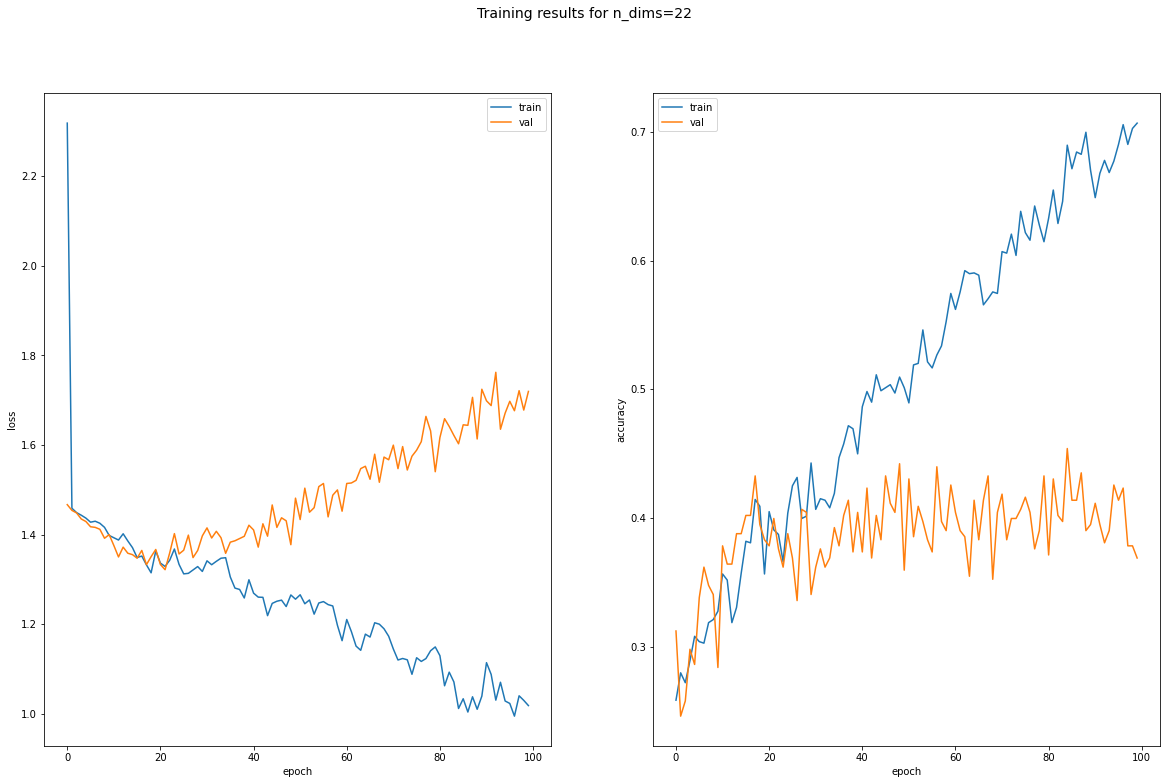

In [27]:
n_ch = 22
n_samples = 1000
n_comp = n_ch
nfs = [100, 250, 10]
conv_sizes = [25, (10, nfs[0]), (5, nfs[1])]
pool_sizes = [20, 10]
pool_strides = [5, 4]
input_dropout = 0.0
fc_dropout = 0.5

# Model init
# model = tf.keras.Sequential()
# model.add(layers.Permute((2, 1), input_shape=(n_ch, 1000)))
# model.add(layers.Dropout(input_dropout, noise_shape=(1, n_ch)))

def ksquare(x):
    return tf.pow(x, 2)

def klog(x):
    return tf.math.log(x)

input_ = layers.Input(shape=(n_comp, n_samples))
# p0 = layers.Permute((2, 1))(input_)
r1 = layers.Reshape(target_shape=(n_comp, n_samples, 1))(input_)
c1 = layers.Conv2D(filters=40, kernel_size=(1,25), data_format='channels_last',
                   activation='elu', kernel_regularizer='l2')(r1)
p1 = layers.Permute(dims=(2,1,3))(c1)
r2 = layers.Reshape((n_samples-24, n_comp*40))(p1)
d1 = layers.Dense(40, activation='elu')(r2)
sq1 = layers.Activation(ksquare)(d1)
ap1 = layers.AveragePooling1D(75, strides=15)(sq1)
log1 = layers.Activation(klog)(ap1)
f1 = layers.Flatten()(log1)
d2 = layers.Dropout(0.80)(f1)
output_ = layers.Dense(4, activation='softmax', kernel_regularizer='l2', kernel_initializer=tf.keras.initializers.RandomNormal(stddev=0.01))(d2)

model = tf.keras.models.Model(inputs=input_, outputs=output_, name='shallow_convnet_one_hot')
# model.compile(optimizer='adam', lr=5e-3, loss='categorical_crossentropy', metrics=['acc'])
model.compile(optimizer=tf.keras.optimizers.Adam(5e-3),
    loss=tf.keras.losses.CategoricalCrossentropy(),
    metrics=[tf.keras.metrics.CategoricalAccuracy()])
model.summary()

loss_hist = model.fit(
    X_train_valid, y_train_valid_1h, 
    batch_size=128,
    validation_split=0.2,
    epochs=100,
    callbacks=[tensorboard_callback]
)
    
    
# loss_hist = model.fit(
#     train_dataset,
#     batch_size=128,
#     epochs=100,
#     validation_data=test_dataset,
#     callbacks=[tensorboard_callback]
# )

hist = loss_hist.history

fig, axs = plt.subplots(1,2, figsize=(20, 12))

fig.suptitle("Training results for n_dims={}".format(n_comp), fontsize=14)

axs[0].plot(hist['loss'])
axs[0].plot(hist['val_loss'])
axs[0].set_ylabel('loss')
axs[0].set_xlabel('epoch')
axs[0].legend(['train', 'val'])

axs[1].plot(hist['categorical_accuracy'])
axs[1].plot(hist['val_categorical_accuracy'])
axs[1].set_ylabel('accuracy')
axs[1].set_xlabel('epoch')
axs[1].legend(['train', 'val'])

# Evaluate model on test dataset
print(model.evaluate(test_dataset))

In [25]:
# %tensorboard --logdir logs/fit

dict_keys(['loss', 'categorical_accuracy', 'val_loss', 'val_categorical_accuracy'])
